In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Facebook = data.DataReader("FB", data_source="yahoo", start = "2004-05-12", end = "2019-06-01")
Facebook.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [3]:
Facebook.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-20,184.229996,181.369995,181.880005,182.720001,10352000,182.720001
2019-05-21,185.699997,183.889999,184.570007,184.820007,7502800,184.820007
2019-05-22,186.740005,183.610001,184.729996,185.320007,9213800,185.320007
2019-05-23,183.899994,179.669998,182.419998,180.869995,12768800,180.869995
2019-05-24,183.630005,180.830002,182.330002,181.059998,8802300,181.059998


In [4]:
Facebook.shape

(1765, 6)

In [5]:
Facebook_train = Facebook.iloc[:1700, :]
Facebook_train.shape

(1700, 6)

In [6]:
Facebook_test = Facebook.iloc[1700:, :]
Facebook_test.shape

(65, 6)

In [7]:
training_set = Facebook.iloc[:1700, 2:3].values
training_set

array([[ 42.04999924],
       [ 36.52999878],
       [ 32.61000061],
       ...,
       [160.5       ],
       [162.25      ],
       [161.92999268]])

In [8]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1699):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set using Keras Callbacks
es = EarlyStopping(monitor='loss', mode='min', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
history = regressor.fit(X_train, y_train, shuffle=True, epochs = 100, callbacks=[es, rlr,mcp, tb],batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Christy\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1639/1639 [==============================] - 47s 29ms/step - loss: 0.0265

Epoch 00001: loss improved from inf to 0.02652, saving model to weights.h5
Epoch 2/100
1639/1639 [==============================] - 36s 22ms/step - loss: 0.0037

Epoch 00002: loss improved from 0.02652 to 0.00373, saving model to weights.h5
Epoch 3/100
1639/1639 [==============================] - 37s 23ms/step - loss: 0.0035

Epoch 00003: loss improved from 0.00373 to 0.00355, saving model to weights.h5
Epoch 4/100
1639/1639 [==============================] - 37s 23ms/step - loss: 0.0032

Epoch 00004: loss improved from 0.00355 to 0.00321, saving model to weights.h5
Epoch 5/100
1639/1639 [==============================] - 37s 23ms/step - loss: 0.0029

Epoch 00005: loss improved from 0.00321 to 0.00291, saving model to weights.h5
Epoch 6/100
1639/1639 [==============================] - 37s 23ms/step - loss: 0.0028

Epoch 00006: loss improved from 0.00291

In [10]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock price until May 2019
real_stock_price = Facebook_test.iloc[:, 2:3].values

In [11]:
# Getting the predicted stock price until May 2019
Facebook_total = pd.concat((Facebook_train['Close'], Facebook_test['Close']), axis = 0)
inputs = Facebook_total[len(Facebook_total) - len(Facebook_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 125):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

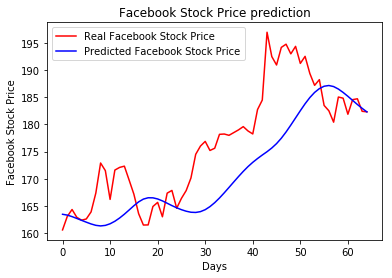

In [12]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Facebook Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Facebook Stock Price')
plt.title('Facebook Stock Price prediction')
plt.xlabel('Days')
plt.ylabel('Facebook Stock Price')
plt.legend()
plt.show()

In [13]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

8.146126451297025

In [14]:
min_val=min(real_stock_price)
max_val=max(real_stock_price)
print ("relative error: ", rmse/(max_val-min_val))

relative error:  [0.22379472]


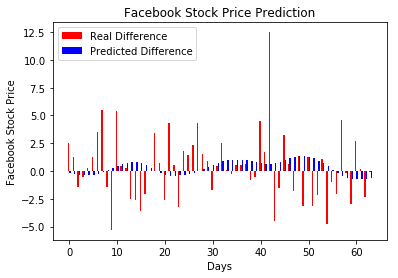

In [15]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Facebook Stock Price Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Facebook Stock Price')
ax.legend()
plt.show()